# import

In [1]:
# basic
import warnings
warnings.filterwarnings('ignore')

import os
import random
import pydicom
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from tqdm.notebook import tqdm

# visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import cv2
!pip install grad-cam
import pytorch_grad_cam
from pytorch_grad_cam import EigenCAM, AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image





# object detection
import json
from skimage.measure import label as sk_label
from skimage.measure import regionprops as sk_regions


# PyTorch
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import models


# object detection
!pip install pycocotools
import pycocotools
from pycocotools.coco import COCO


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=06cd813eb5fa6467439bfcb21d9a93355cf608ce14bf44dd5a0a204d41dd5b9e
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 2.9 MB/s eta 0:00:00


In [2]:
class config:
    root = "/kaggle/input/miadl5/hwk05_data"
    root_2 = "/kaggle/working/"
    num_classes = 8
    batch_size = 4
    epochs = 30
    weight_decay = 0.0005
    lr = 0.0060229
    momentum = 0.9
    milestones = [16, 22]
    gamma = 0.1
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    categories = ['normal', 'aortic_curvature', 'aortic_atherosclerosis_calcification', 
                  'cardiac_hypertrophy', 'intercostal_pleural_thickening', 'lung_field_infiltration', 
                  'degenerative_joint_disease_of_the_thoracic_spine', 'scoliosis']

In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(config.seed)

In [4]:
# training dataframe
train_df = pd.read_csv("/kaggle/input/miadl5/hwk05_data/train_UTF8.csv")
train_df

ID category  Width  Height    Filename  \
0    TDR04_20180315_075734   normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518   normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322   normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746   normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113   normal   2144    2384  220_91.dcm   
..                     ...      ...    ...     ...         ...   
446  TDR02_20161209_161439     脊椎側彎   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933     脊椎側彎   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354     脊椎側彎   2488    2456    4440.dcm   
449  TDR01_20171106_095308     脊椎側彎   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516     脊椎側彎   2280    2288   A0_28.dcm   

                    ImagePath                     MarkPath  
0    /normal/image/220_97.dcm  /normal/mark/220_97.dcm.jpg  
1    /normal/image/220_94.dcm  /normal/mark/220_94.dcm.jpg  
2    /normal/image/220_93.dcm  /normal/mark/220_93.dcm.jpg  
3    /normal/image/220_92.dcm  /normal/mark/220_92.dcm.jpg  
4    /normal/image/220_91.dcm  /normal/mark/220_91.dcm.jpg  
..                        ...                          ...  
446    /脊椎側彎/image/4440_5.dcm    /脊椎側彎/mark/4440_5.dcm.jpg  
447    /脊椎側彎/image/4440_0.dcm    /脊椎側彎/mark/4440_0.dcm.jpg  
448      /脊椎側彎/image/4440.dcm      /脊椎側彎/mark/4440.dcm.jpg  
449     /脊椎側彎/image/A0_29.dcm     /脊椎側彎/mark/A0_29.dcm.jpg  
450     /脊椎側彎/image/A0_28.dcm     /脊椎側彎/mark/A0_28.dcm.jpg  

[451 rows x 7 columns]

# 整理資料
更改類別名稱為英文

In [5]:
# all classes
category = {
    "心臟肥大": "cardiac_hypertrophy",
    "主動脈硬鈣化": "aortic_atherosclerosis_calcification",
    "主動脈彎曲": "aortic_curvature",
    "肺尖肋膜增厚": "intercostal_pleural_thickening",
    "肺野浸潤增加": "lung_field_infiltration",
    "胸椎退化性關節病變": "degenerative_joint_disease_of_the_thoracic_spine",
    "脊椎側彎": "scoliosis",
    "normal": "normal"
}
# change category names to English
def change_to_eng_names(df):
    
    df["category"] = df["category"].apply(lambda x: category[x])
    df["ImagePath"] = df.apply(lambda df: "/".join([df["category"], "image", df["Filename"]]), axis=1)
    df["MarkPath"] = df.apply(lambda df: "/".join([df["category"], "mark", df["Filename"] + ".jpg"]), axis=1)


change_to_eng_names(train_df)
train_df

ID   category  Width  Height    Filename  \
0    TDR04_20180315_075734     normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518     normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322     normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746     normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113     normal   2144    2384  220_91.dcm   
..                     ...        ...    ...     ...         ...   
446  TDR02_20161209_161439  scoliosis   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933  scoliosis   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354  scoliosis   2488    2456    4440.dcm   
449  TDR01_20171106_095308  scoliosis   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516  scoliosis   2280    2288   A0_28.dcm   

                      ImagePath                       MarkPath  
0       normal/image/220_97.dcm     normal/mark/220_97.dcm.jpg  
1       normal/image/220_94.dcm     normal/mark/220_94.dcm.jpg  
2       normal/image/220_93.dcm     normal/mark/220_93.dcm.jpg  
3       normal/image/220_92.dcm     normal/mark/220_92.dcm.jpg  
4       normal/image/220_91.dcm     normal/mark/220_91.dcm.jpg  
..                          ...                            ...  
446  scoliosis/image/4440_5.dcm  scoliosis/mark/4440_5.dcm.jpg  
447  scoliosis/image/4440_0.dcm  scoliosis/mark/4440_0.dcm.jpg  
448    scoliosis/image/4440.dcm    scoliosis/mark/4440.dcm.jpg  
449   scoliosis/image/A0_29.dcm   scoliosis/mark/A0_29.dcm.jpg  
450   scoliosis/image/A0_28.dcm   scoliosis/mark/A0_28.dcm.jpg  

[451 rows x 7 columns]

# 畫出8種類別的第一張 image & mask 位置
這裡如果類別是 normal，就自行生成一個 shape 和原始影像相同的 mask。

In [6]:
temp = train_df[train_df["category"].duplicated() == False]
temp

ID                                          category  \
0    TDR04_20180315_075734                                            normal   
80   TDR04_20180227_083423                                  aortic_curvature   
132  TDR01_20190313_090724              aortic_atherosclerosis_calcification   
203  TDR04_20180226_090403                               cardiac_hypertrophy   
236  TDR05_20151105_094209                    intercostal_pleural_thickening   
265  TDR04_20180227_083423                           lung_field_infiltration   
333  TDR04_20180227_085056  degenerative_joint_disease_of_the_thoracic_spine   
393  TDR01_20171109_083459                                         scoliosis   

     Width  Height    Filename  \
0     2328    2344  220_97.dcm   
80    2504    2536  220_14.dcm   
132   2392    2600   10_1d.dcm   
203   2008    2280    4440.dcm   
236   2296    2512  4440_4.dcm   
265   2504    2536   220_3.dcm   
333   2336    2360  220_15.dcm   
393   2232    2408   A0_26.dcm   

                                             ImagePath  \
0                              normal/image/220_97.dcm   
80                   aortic_curvature/image/220_14.dcm   
132  aortic_atherosclerosis_calcification/image/10_...   
203                 cardiac_hypertrophy/image/4440.dcm   
236    intercostal_pleural_thickening/image/4440_4.dcm   
265            lung_field_infiltration/image/220_3.dcm   
333  degenerative_joint_disease_of_the_thoracic_spi...   
393                          scoliosis/image/A0_26.dcm   

                                              MarkPath  
0                           normal/mark/220_97.dcm.jpg  
80                aortic_curvature/mark/220_14.dcm.jpg  
132  aortic_atherosclerosis_calcification/mark/10_1...  
203              cardiac_hypertrophy/mark/4440.dcm.jpg  
236  intercostal_pleural_thickening/mark/4440_4.dcm...  
265         lung_field_infiltration/mark/220_3.dcm.jpg  
333  degenerative_joint_disease_of_the_thoracic_spi...  
393                       scoliosis/mark/A0_26.dcm.jpg

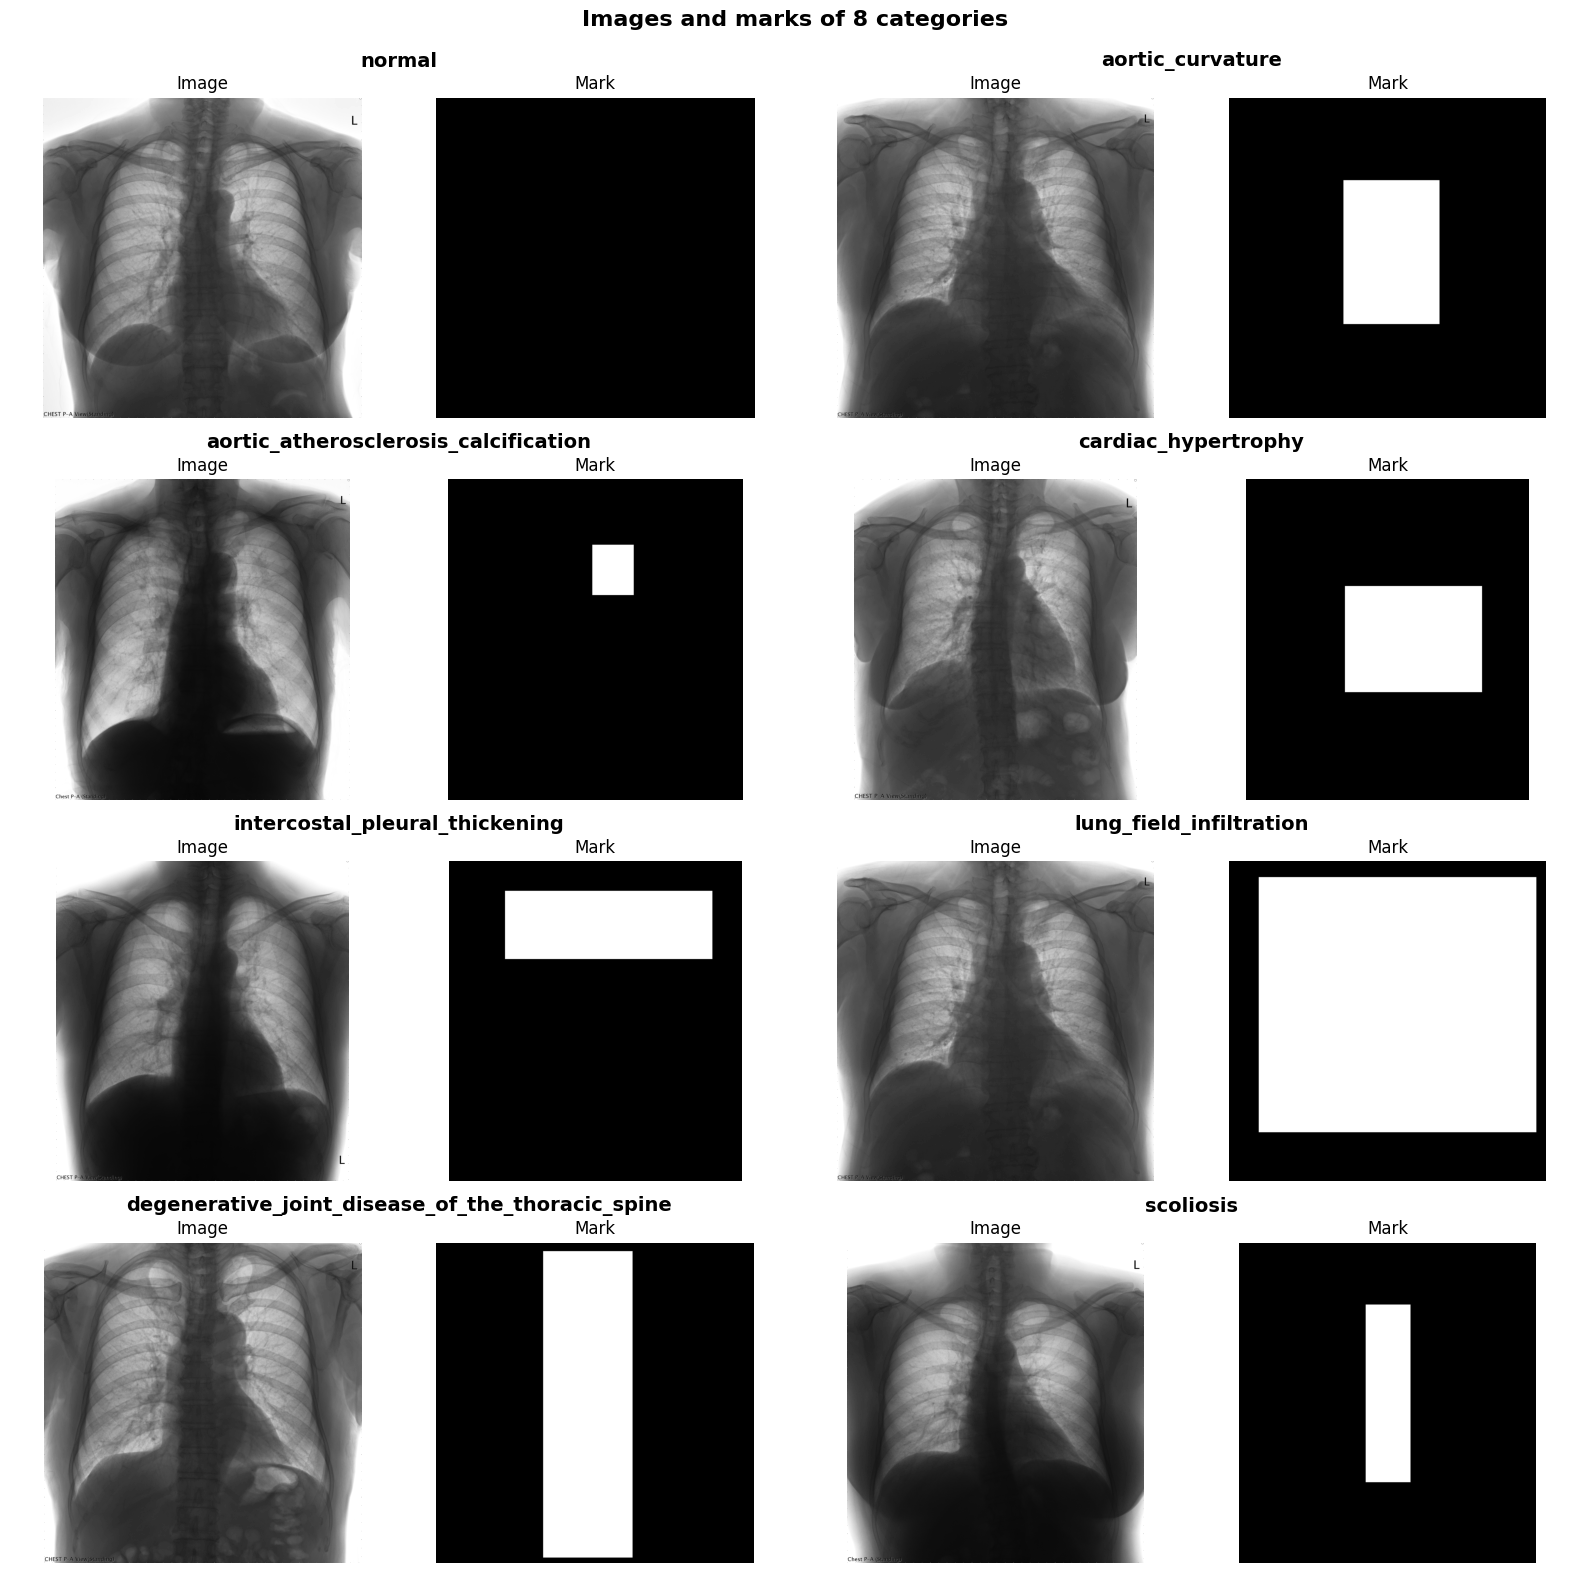

In [7]:
def plot_images_and_marks(df):
    
    temp = df[df["category"].duplicated() == False]
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (16, 16))
    grid = plt.GridSpec(rows, cols)
    
    for i in range(rows * cols):
        image = pydicom.dcmread(os.path.join(config.root, "train", temp.iloc[i, 5])).pixel_array
        if temp.iloc[i, 1] != "normal":
            mark = np.array(Image.open(os.path.join(config.root, "train", temp.iloc[i, 6])))
        else:
            mark = np.zeros((image.shape[0], image.shape[1]))
        
        categories = fig.add_subplot(grid[i])
        categories.set_title(f"{temp.iloc[i, 1]}\n", fontweight = 'semibold', size = 14)
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image, cmap = "gray")
        ax.set_title("Image")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[1], sharey = ax)
        ax.imshow(mark, cmap = "gray")
        ax.set_title("Mark")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("Images and marks of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()
      
plot_images_and_marks(train_df)

# X-ray image normalization
這部分需完成 intensity log-transformation 跟 simplest color balance algorithm ，目的是為了轉換影像型態及調整 L & R 字樣的亮度。

以 ID 為 TDR02_20161209_161439 的病患為例，輸出轉換前及轉換後的 X-ray 影像：

In [8]:
def X_ray_normalization(dcm_file, vmin, vmax):
    
    img = pydicom.dcmread(dcm_file)
    origin = img.pixel_array
    
    # needed values
    WW = img.WindowWidth
    WC = img.WindowCenter
    BitsStored = img.BitsStored

    iMax = WC + (WW / 2)
    iMin = WC - (WW / 2)
    
    # intensity log-transformation
    log_img = np.clip(origin, iMin, iMax)
    log_img = - np.log((1 + log_img)/(2 ** BitsStored))
    
    # simplest color balance algorithm
    normalize_img = (log_img - vmin) / (vmax - vmin)
    normalize_img = np.clip(normalize_img, 0, 1)
    
    return origin, log_img, normalize_img

<Figure size 1600x1600 with 0 Axes>

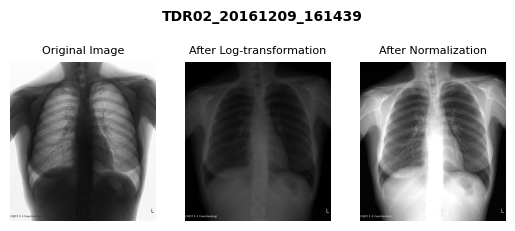

In [9]:
def plot_before_and_after(ID, df):
    
    patient_df = df[df["ID"] == ID]
    path = os.path.join(config.root, "train", patient_df.iloc[0, 5])
    origin, log_img, normalize_img = X_ray_normalization(path, vmin = 0, vmax = 2.5)
    
    plt.figure(figsize = (16, 16))
    fig, ax = plt.subplots(1, 3)
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    plt.subplots_adjust(wspace = None, hspace = None)
    
    ax[0].imshow(origin, cmap = "gray")
    ax[0].set_title("Original Image", size = 8)
    ax[1].imshow(log_img, cmap = "gray")
    ax[1].set_title("After Log-transformation", size = 8)
    ax[2].imshow(normalize_img, cmap = "gray")
    ax[2].set_title("After Normalization", size = 8)
          
    fig.suptitle(f"{ID}", fontweight = 'bold', size = 10, x = 0.52, y = 0.77)
    
plot_before_and_after(ID = "TDR02_20161209_161439", df = train_df)

# Mask image to bounding box
這部分將資料集中的 mask 轉換為丟入模型所需的 bounding box，並畫出8種類別的轉換後影像、轉換後影像及 bounding box，以及 mask 影像：

In [10]:
mark_path = os.path.join(config.root, "train",'aortic_curvature/mark/220_14.dcm.jpg')
img = np.array(Image.open(mark_path))
mask = img != 0
xs = np.where(np.sum(mask,axis = 0)>0)[0]
ys = np.where(np.sum(mask,axis = 1)>0)[0]

ymin, xmin, ymax, xmax = ys[0],xs[0],ys[-1],xs[-1]

ymin, xmin, ymax, xmax

(656, 904, 1799, 1663)

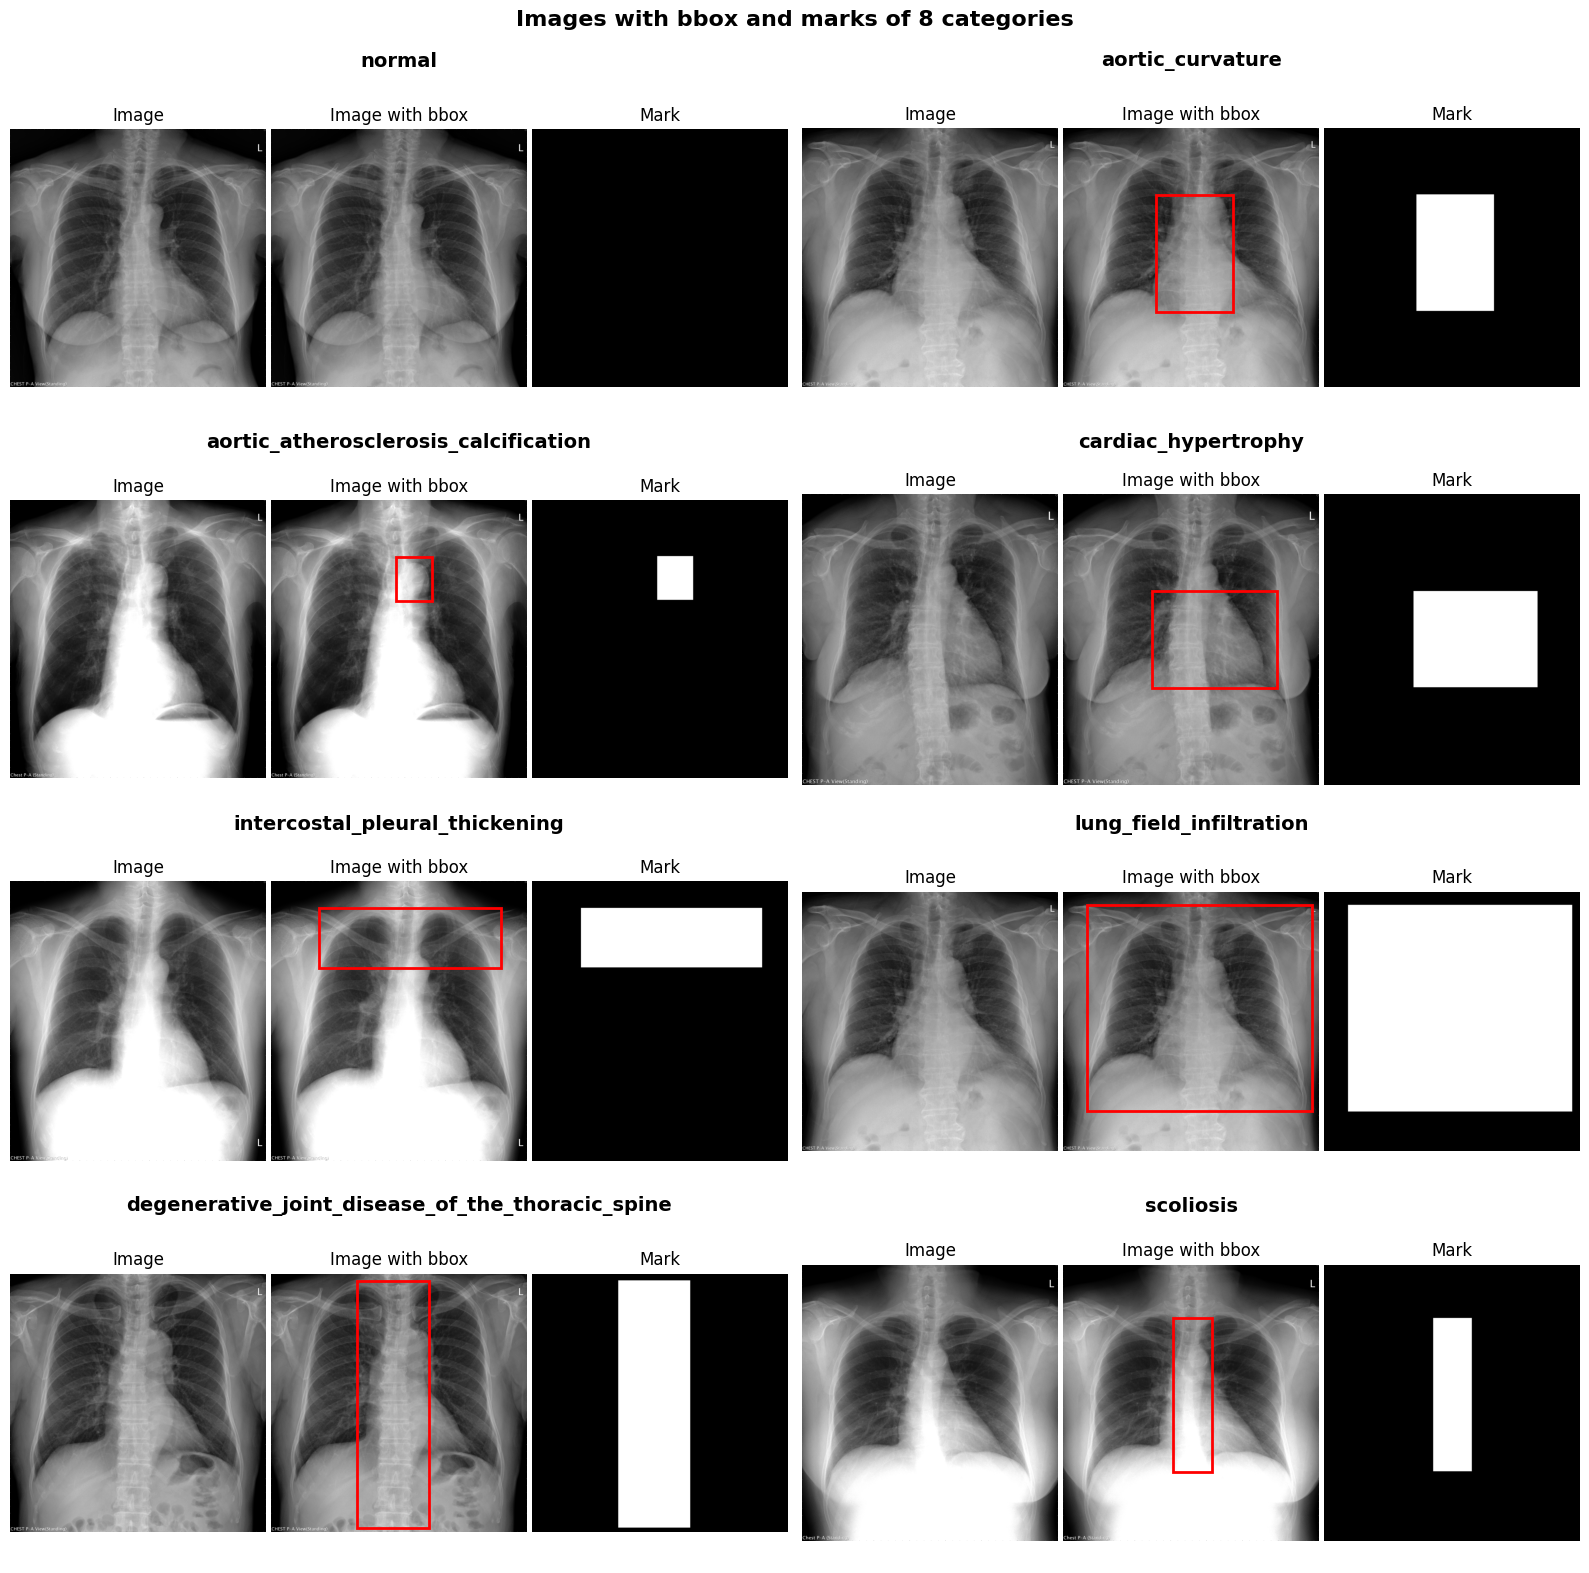

In [11]:
# def mask_to_bbox(mark_path):
#     img = np.array(Image.open(mark_path))

#     mask = img != 0
#     sk_mask = sk_label(mask, connectivity = 2)
#     regions = sk_regions(sk_mask)
#     bboxes = []
#     for region in regions:
#         if region.area < 3000 :
#             continue
#         bboxes.append(region.bbox)

#     ymin, xmin, ymax, xmax = bboxes[0]
    
#     return xmin, ymin, xmax, ymax

def mask_to_bbox(mark_path):
    img = np.array(Image.open(mark_path))
    mask = img != 0
    xs = np.where(np.sum(mask,axis = 0)>0)[0]
    ys = np.where(np.sum(mask,axis = 1)>0)[0]

    ymin, xmin, ymax, xmax = ys[0],xs[0],ys[-1],xs[-1]
    return xmin, ymin, xmax, ymax

def plot_bbox_and_mark(df):
    
    temp = df[df["category"].duplicated() == False]
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (16, 16))
    grid = plt.GridSpec(rows, cols)
    
    for i in range(rows * cols):
        
        path = os.path.join(config.root, "train", temp.iloc[i, 5])
        mark_path = os.path.join(config.root, "train", temp.iloc[i, 6])
        
        _, _, after = X_ray_normalization(path, vmin = 0, vmax = 2.5)
        
        if temp.iloc[i, 1] != "normal":
            mark = np.array(Image.open(mark_path))
            xmin, ymin, xmax, ymax = mask_to_bbox(mark_path)
        else:
            mark = np.zeros((after.shape[0], after.shape[1]))
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        
        bbox = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 2, 
                                 edgecolor = "r", facecolor = 'none')
        
        categories = fig.add_subplot(grid[i])
        categories.set_title(f"{temp.iloc[i, 1]}\n", fontweight = 'semibold', size = 14)
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(after, cmap = "gray")
        ax.set_title("Image")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[1], sharey = ax)
        ax.imshow(after, cmap = "gray")
        ax.add_patch(bbox)
        ax.set_title("Image with bbox")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[2], sharey = ax)
        ax.imshow(mark, cmap = "gray")
        ax.set_title("Mark")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("Images with bbox and marks of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()
      
plot_bbox_and_mark(train_df)

接著將轉換出的 bounding box 寫入 training dataframe 中：

In [12]:
def write_bbox(df):
    
    all_xmin, all_ymin, all_xmax, all_ymax = [], [], [], []
    
    for i in range(df.shape[0]):
        
        if df.iloc[i, 1] != "normal":
            mark_path = os.path.join(config.root, "train", df.iloc[i, 6])
            xmin, ymin, xmax, ymax = mask_to_bbox(mark_path)
        else:
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        
        all_xmin.append(xmin)
        all_ymin.append(ymin)
        all_xmax.append(xmax)
        all_ymax.append(ymax)
        
    df["xmin"] = all_xmin
    df["ymin"] = all_ymin
    df["xmax"] = all_xmax
    df["ymax"] = all_ymax
    
write_bbox(train_df)
train_df

ID   category  Width  Height    Filename  \
0    TDR04_20180315_075734     normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518     normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322     normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746     normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113     normal   2144    2384  220_91.dcm   
..                     ...        ...    ...     ...         ...   
446  TDR02_20161209_161439  scoliosis   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933  scoliosis   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354  scoliosis   2488    2456    4440.dcm   
449  TDR01_20171106_095308  scoliosis   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516  scoliosis   2280    2288   A0_28.dcm   

                      ImagePath                       MarkPath  xmin  ymin  \
0       normal/image/220_97.dcm     normal/mark/220_97.dcm.jpg     0     0   
1       normal/image/220_94.dcm     normal/mark/220_94.dcm.jpg     0     0   
2       normal/image/220_93.dcm     normal/mark/220_93.dcm.jpg     0     0   
3       normal/image/220_92.dcm     normal/mark/220_92.dcm.jpg     0     0   
4       normal/image/220_91.dcm     normal/mark/220_91.dcm.jpg     0     0   
..                          ...                            ...   ...   ...   
446  scoliosis/image/4440_5.dcm  scoliosis/mark/4440_5.dcm.jpg  1016   560   
447  scoliosis/image/4440_0.dcm  scoliosis/mark/4440_0.dcm.jpg   912   552   
448    scoliosis/image/4440.dcm    scoliosis/mark/4440.dcm.jpg  1016   464   
449   scoliosis/image/A0_29.dcm   scoliosis/mark/A0_29.dcm.jpg  1032   512   
450   scoliosis/image/A0_28.dcm   scoliosis/mark/A0_28.dcm.jpg   912   592   

     xmax  ymax  
0       0     0  
1       0     0  
2       0     0  
3       0     0  
4       0     0  
..    ...   ...  
446  1431  2327  
447  1407  2271  
448  1559  2183  
449  1383  2015  
450  1391  2119  

[451 rows x 11 columns]

# Write class id
因之後轉換資料格式所需，我們需要把疾病類別改寫為 class_id，也就是 0 ~ 7 的數字。

In [13]:
labels = list(train_df["category"].unique())
label2class = {l: c for c, l in enumerate(labels)}
label2class

{'normal': 0,
 'aortic_curvature': 1,
 'aortic_atherosclerosis_calcification': 2,
 'cardiac_hypertrophy': 3,
 'intercostal_pleural_thickening': 4,
 'lung_field_infiltration': 5,
 'degenerative_joint_disease_of_the_thoracic_spine': 6,
 'scoliosis': 7}

In [14]:
# write class_id
def write_class_id(df):
    class_id = []
    for i in range(df.shape[0]):
        class_id.append(label2class[df.iloc[i, 1]])
    df["class_id"] = class_id
    
write_class_id(train_df)
train_df

ID   category  Width  Height    Filename  \
0    TDR04_20180315_075734     normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518     normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322     normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746     normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113     normal   2144    2384  220_91.dcm   
..                     ...        ...    ...     ...         ...   
446  TDR02_20161209_161439  scoliosis   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933  scoliosis   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354  scoliosis   2488    2456    4440.dcm   
449  TDR01_20171106_095308  scoliosis   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516  scoliosis   2280    2288   A0_28.dcm   

                      ImagePath                       MarkPath  xmin  ymin  \
0       normal/image/220_97.dcm     normal/mark/220_97.dcm.jpg     0     0   
1       normal/image/220_94.dcm     normal/mark/220_94.dcm.jpg     0     0   
2       normal/image/220_93.dcm     normal/mark/220_93.dcm.jpg     0     0   
3       normal/image/220_92.dcm     normal/mark/220_92.dcm.jpg     0     0   
4       normal/image/220_91.dcm     normal/mark/220_91.dcm.jpg     0     0   
..                          ...                            ...   ...   ...   
446  scoliosis/image/4440_5.dcm  scoliosis/mark/4440_5.dcm.jpg  1016   560   
447  scoliosis/image/4440_0.dcm  scoliosis/mark/4440_0.dcm.jpg   912   552   
448    scoliosis/image/4440.dcm    scoliosis/mark/4440.dcm.jpg  1016   464   
449   scoliosis/image/A0_29.dcm   scoliosis/mark/A0_29.dcm.jpg  1032   512   
450   scoliosis/image/A0_28.dcm   scoliosis/mark/A0_28.dcm.jpg   912   592   

     xmax  ymax  class_id  
0       0     0         0  
1       0     0         0  
2       0     0         0  
3       0     0         0  
4       0     0         0  
..    ...   ...       ...  
446  1431  2327         7  
447  1407  2271         7  
448  1559  2183         7  
449  1383  2015         7  
450  1391  2119         7  

[451 rows x 12 columns]


# Split training set and validation set
這裡要注意的是，由於一張影像可能包含許多類不同疾病 ( multi-label ) ，所以在切分 training set 跟 validation set 時不能用一般的 train_test_split ，否則會導致類別不平衡。此外，由於一名病人在 dataframe 中可能有多筆資料，所以分的時候記得要用 ID 去分！

首先把疾病類別改寫為 one-hot encoding 形式

In [15]:

binarizer = MultiLabelBinarizer()
disease_id = []
for ID in train_df.ID.unique():
    diseases = []
    temp = train_df[train_df["ID"] == ID]
    diseases.extend(list(temp["class_id"]))
    disease_id.append(diseases)

one_hot = binarizer.fit_transform(disease_id)
one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [16]:
train_ID, train_label, val_ID, val_label = iterative_train_test_split(np.expand_dims(train_df["ID"].unique(), axis = 1), one_hot, test_size = 0.2)

training = train_df[train_df["ID"].isin(train_ID.ravel())]
validation = train_df[train_df["ID"].isin(val_ID.ravel())]

# Dataset to COCO format


In [17]:
categories = []
for l, c in label2class.items():
    if l == "normal":
        continue
    categories.append({"id": c, "name": l})

In [18]:
def coco_format(df, categories):
    coco_output = {
        "images" : [],
        "categories" : [],
        "annotations" : []
        }
 
    coco_output['categories'] = categories

    annotation_id = 0
    for image_id, img_name in enumerate(df.ID.unique()):
        image_df = df[df.ID == img_name]
        if len(image_df) == 1:
            image_dict = {
                "file_name" : list(image_df.category)[0] + "/" + list(image_df.Filename)[0].replace(".dcm", ".jpg"),
                "height" : int(image_df.Height),
                "width" : int(image_df.Width),
                "id" : image_id
                }
        else:
            unique = image_df.iloc[0, :]
            image_dict = {
                "file_name" : unique.category + "/" + unique.Filename.replace(".dcm", ".jpg"),
                "height" : int(unique.Height),
                "width" : int(unique.Width),
                "id" : image_id
                }  
        coco_output['images'].append(image_dict)

        for _, row in image_df.iterrows():
            xmin = int(row.xmin)
            ymin = int(row.ymin)
            xmax = int(row.xmax)
            ymax = int(row.ymax)
            if xmin == ymin == xmax == ymax == 0:
                continue

            area = (xmax - xmin) * (ymax - ymin)
          
            poly = [
                (xmin, ymin), (xmax, ymin), 
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))

            mask_dict = {
                "id" : annotation_id,
                "image_id" : image_id,
                "category_id" : row.class_id,
                "bbox" : [xmin, ymin, (xmax - xmin), (ymax - ymin)],
                "area" : area,
                "iscrowd" : 0, 
                "segmentation" : [poly],
                }
            coco_output["annotations"].append(mask_dict)
            annotation_id += 1

    return coco_output

# Save files

In [19]:
def dcm_to_jpg(df):
    
    for path in df.ImagePath:
        dcm_path = os.path.join(config.root, "train", path)
        _, _, image = X_ray_normalization(dcm_path, vmin = 0, vmax = 2.5)
        file = os.path.join("/kaggle/working/", path.split("/")[0])
        jpg_name = path.split("/")[-1].replace(".dcm", ".jpg")
        
        if os.path.isdir(file) == False:
            os.makedirs(file)
        
        plt.imsave(f"{file}/{jpg_name}", image, cmap = "gray")

In [20]:
dcm_to_jpg(train_df)

In [21]:
train_coco = coco_format(training, categories)
with open("train.json", "w") as outfile:
    json.dump(train_coco, outfile)
    
val_coco = coco_format(validation, categories)
with open("val.json", "w") as outfile:
    json.dump(val_coco, outfile)

# 2

In [22]:
# basic
from tqdm.notebook import tqdm

# visualization
import cv2


# PyTorch
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# object detection
!pip install pycocotools
import pycocotools
from pycocotools.coco import COCO

為了使用 COCO API 來評估模型成效，我們會需要用到以下五個檔案，以下為 source code：

https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

In [23]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
    
from engine import evaluate

--2024-01-10 06:35:05--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: 'engine.py'

engine.py           100%[===================>]   3.97K  --.-KB/s    in 0s      

2024-01-10 06:35:05 (75.4 MB/s) - 'engine.py' saved [4063/4063]

--2024-01-10 06:35:06--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

# Read data information
我們可以利用 pycocotools 這個套件來讀取 .json 檔案中的資料，此處簡單介紹我們所創建的 COCO dataset 所包含的三個部分：

## Categories
包含所有類別的 dictionary ( 不含 background ) ，每個 dictionary 中需要 2 個 key :

id : 類別編號
name : 類別名稱

In [24]:
annfile = config.root_2 + "train.json"
coco = COCO(annfile)
coco.cats

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{1: {'id': 1, 'name': 'aortic_curvature'},
 2: {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 3: {'id': 3, 'name': 'cardiac_hypertrophy'},
 4: {'id': 4, 'name': 'intercostal_pleural_thickening'},
 5: {'id': 5, 'name': 'lung_field_infiltration'},
 6: {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 7: {'id': 7, 'name': 'scoliosis'}}

## Images
影像相關資訊，一個 dictionary 含一張影像，內有 4 個 key :

file_name : 影像路徑

height : 影像高度

width : 影像寬度

id : 影像編號 ( unique )

In [25]:
coco.loadImgs(80)

[{'file_name': 'aortic_curvature/4440_6.jpg',
  'height': 2624,
  'width': 2216,
  'id': 80}]

## Annotations
標註相關資訊，一個 dictionary 只包含一個 annotation ( bounding box ) ，共有 7 個 key :

id : 該 annotation 的編號

image_id : 該 bounding box 所屬影像的編號

category_id : 該 bounding box 所屬類別的編號

bbox : bounding box 的標註資訊，格式為
  [
xmin
,
ymin
,
width
,
height
]  
xmin和ymin表示 bounding box 左上角在影像上的座標， 
width和height則為 bounding box 的寬跟高
  
area : 每個 bounding box 所圍出的面積。

iscrowd : 是單一物件 ( 0 ) 或一組物件 ( 1 )。segmentation 時使用，此處直接設為 0 即可

segmentation : segmentation 時使用，可忽略

In [26]:
ann_ids = coco.getAnnIds(imgIds = 80)
coco.loadAnns(ann_ids)

[{'id': 32,
  'image_id': 80,
  'category_id': 1,
  'bbox': [816, 664, 591, 1263],
  'area': 746433,
  'iscrowd': 0,
  'segmentation': [[816, 664, 1407, 664, 1407, 1927, 816, 1927]]},
 {'id': 33,
  'image_id': 80,
  'category_id': 2,
  'bbox': [1080, 672, 295, 335],
  'area': 98825,
  'iscrowd': 0,
  'segmentation': [[1080, 672, 1375, 672, 1375, 1007, 1080, 1007]]}]

# Data augmentation
由於經過 transform 後，圖片中的 bounding box 的位置與大小也會跟著改變，因此要將 bounding box 也一起進行轉換。

In [27]:
def get_transforms(train = False):
    
    if train:
        transform = A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p = 0.3),
            A.RandomBrightnessContrast(p = 0.1),
            A.ColorJitter(p = 0.1),
            ToTensorV2()
        ], bbox_params = A.BboxParams(format = "coco"))
    else:
        transform = A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ], bbox_params = A.BboxParams(format = "coco"))
    
    return transform

Dataset
在 Dataset 的部分，我們需要回傳的東西有兩項：image 和 target。

image 與先前作業沒有太大差異，只有讀取方式有所不同。至於 target 則是一個 dictionary，裡面需包含 5 個 key：

1.boxes：該影像中所有 bounding box 的標註，格式為  
[
xmin
,
ymin
,
xmax
,
ymax
]
 。   
xmin和ymin表示 bounding box 左上角在影像上的座標， 
xmax和ymax則表示 bounding box 右下角在影像上的座標  
  
2.labels：每個 bounding box 所對應的疾病類別  
3.image_id：影像編號  
4.area：每個 bounding box 所圍出的面積。若 bounding box 有經過 transform，一定要記得重新計算  
5.iscrowd：是單一物件 ( 0 ) 或一組物件 ( 1 )。segmentation 時使用，此處直接設為 0 即可  

In [28]:
class CXRDataset(Dataset):
    
    def __init__(self, root, split, transforms = None):
        self.split = split
        self.root = root
        self.transforms = transforms
        self.coco = COCO(os.path.join(config.root_2, f"{self.split}.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [img_id for img_id in self.ids if (len(self.get_annotation(img_id)) > 0)]
    
    def get_image(self, img_id: int):
        image_path = self.coco.loadImgs(img_id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image
    
    def get_annotation(self, img_id: int):
        annotation = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        
        return annotation
          
    def __getitem__(self, index):
        img_id = self.ids[index]
        image = self.get_image(img_id)
        annotation = self.get_annotation(img_id)
        bboxes = [a['bbox'] + [a['category_id']] for a in annotation]
        
        if self.transforms:
            transformed = self.transforms(image = image, bboxes = bboxes)
        
        image = transformed['image'] / 255
        bboxes = transformed['bboxes']
        
        new_bboxes = list(map(lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]], bboxes))
        new_bboxes = torch.tensor(new_bboxes, dtype = torch.float32)
        
        target = {}
        target['boxes'] = new_bboxes
        target['labels'] = torch.tensor([a['category_id'] for a in annotation], dtype = torch.int64)
        target['image_id'] = img_id
        target['area'] = (new_bboxes[:, 3] - new_bboxes[:, 1]) * (new_bboxes[:, 2] - new_bboxes[:, 0])
        target['iscrowd'] = torch.tensor([a['iscrowd'] for a in annotation], dtype = torch.int64)
        
        return image, target
        
    def __len__(self):
        return len(self.ids)

# Collate_fn
用於 dataloader。由於 object detection 讀取 data 的方式與先前的 classification 和 segmentation 有所不同，因此需自定義 collate_fn。
此處有沒有加 tuple() 都沒關係。

In [29]:
def collate_fn(batch: list[torch.tensor, dict]):
    return tuple(zip(*batch))

# Model: Faster R-CNN
這邊使用 torchvision 中內建的 Faster R-CNN 模型，並加載預訓練權重，但要記得更改 predictor 的類別數量為 8 類 ( 含 background，也就是 normal ) ，如下所示：

In [30]:
def fasterrcnn(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Training
在 PyTorch 的 Faster R-CNN 這個模型中，我們不須再自行定義 loss function，因為在model.train() 下，model(images, targets) 會自動回傳訓練的 loss，其包含以下四種損失：

1.loss_classifier：分類器之損失  
2.loss_box_reg：bounding box regressor 之損失  
3.loss_rpn_box_reg：RPN 中 bounding box regressor 之損失  
4.loss_objectness：RPN 中分類器之損失，此分類器用以判斷 bounding box 中是否包含物體

總損失為這四種 loss 的總和。

In [31]:
def train_one_epoch(model, train_loader, optimizer, scheduler, device):
    model.train()
    
    train_loss = []
    train_loss_dict = []
    
    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        
        loss = model(images, targets)
        total_loss = sum(l for l in loss.values())
        loss_value = total_loss.item()
        loss_dict = {k: v.item() for k, v in loss.items()}
        train_loss.append(loss_value)
        train_loss_dict.append(loss_dict)
        
        total_loss.backward()
        optimizer.step()
    scheduler.step()
        
    train_loss = np.mean(train_loss)
    
    train_loss_dict = pd.DataFrame(train_loss_dict)
    train_loss_classifier = train_loss_dict['loss_classifier'].mean()
    train_loss_box_reg = train_loss_dict['loss_box_reg'].mean()
    train_loss_rpn_box_reg = train_loss_dict['loss_rpn_box_reg'].mean()
    train_loss_objectness = train_loss_dict['loss_objectness'].mean()
    
    return train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness

In [32]:
@torch.no_grad()
def validation(model, val_loader, device):
    model.train()
    
    for m in model.modules():
        if isinstance(m, torchvision.ops.Conv2dNormActivation):
            m.eval()
    
    val_loss = []
    val_loss_dict = []
    
    for images, targets in tqdm(val_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss = model(images, targets)
        total_loss = sum(l for l in loss.values())
        loss_value = total_loss.item()
        loss_dict = {k: v.item() for k, v in loss.items()}
        val_loss.append(loss_value)
        val_loss_dict.append(loss_dict)
    
    val_loss = np.mean(val_loss)
    
    val_loss_dict = pd.DataFrame(val_loss_dict)
    val_loss_classifier = val_loss_dict['loss_classifier'].mean()
    val_loss_box_reg = val_loss_dict['loss_box_reg'].mean()
    val_loss_rpn_box_reg = val_loss_dict['loss_rpn_box_reg'].mean()
    val_loss_objectness = val_loss_dict['loss_objectness'].mean()
    
    return val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 224MB/s]


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/30 | LR: 0.006023
*****Training*****
Loss: 0.3315 | Classifier Loss: 0.1871 | Box Reg Loss: 0.1190 | RPN Box Reg Loss: 0.0081 | Objectness Loss: 0.0173
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3823 (0.3823)  evaluator_time: 0.0166 (0.0166)  time: 0.6137  data: 0.2113  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3103 (0.3095)  evaluator_time: 0.0130 (0.0135)  time: 0.5494  data: 0.2258  max mem: 3176
Test: Total time: 0:00:29 (0.5511 s / it)
Averaged stats: model_time: 0.3103 (0.3095)  evaluator_time: 0.0130 (0.0135)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 2/30 | LR: 0.006023
*****Training*****
Loss: 0.2483 | Classifier Loss: 0.1129 | Box Reg Loss: 0.1215 | RPN Box Reg Loss: 0.0068 | Objectness Loss: 0.0071
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3801 (0.3801)  evaluator_time: 0.0111 (0.0111)  time: 0.6146  data: 0.2200  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3372 (0.3339)  evaluator_time: 0.0102 (0.0106)  time: 0.5701  data: 0.2227  max mem: 3176
Test: Total time: 0:00:30 (0.5718 s / it)
Averaged stats: model_time: 0.3372 (0.3339)  evaluator_time: 0.0102 (0.0106)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 3/30 | LR: 0.006023
*****Training*****
Loss: 0.2109 | Classifier Loss: 0.0974 | Box Reg Loss: 0.1006 | RPN Box Reg Loss: 0.0063 | Objectness Loss: 0.0066
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3955 (0.3955)  evaluator_time: 0.0095 (0.0095)  time: 0.6349  data: 0.2266  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3331 (0.3297)  evaluator_time: 0.0094 (0.0093)  time: 0.5725  data: 0.2302  max mem: 3176
Test: Total time: 0:00:30 (0.5702 s / it)
Averaged stats: model_time: 0.3331 (0.3297)  evaluator_time: 0.0094 (0.0093)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 4/30 | LR: 0.006023
*****Training*****
Loss: 0.1769 | Classifier Loss: 0.0862 | Box Reg Loss: 0.0811 | RPN Box Reg Loss: 0.0055 | Objectness Loss: 0.0041
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3700 (0.3700)  evaluator_time: 0.0100 (0.0100)  time: 0.6058  data: 0.2224  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3302 (0.3261)  evaluator_time: 0.0090 (0.0093)  time: 0.5606  data: 0.2224  max mem: 3176
Test: Total time: 0:00:29 (0.5651 s / it)
Averaged stats: model_time: 0.3302 (0.3261)  evaluator_time: 0.0090 (0.0093)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 5/30 | LR: 0.006023
*****Training*****
Loss: 0.1670 | Classifier Loss: 0.0817 | Box Reg Loss: 0.0761 | RPN Box Reg Loss: 0.0053 | Objectness Loss: 0.0038
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:34  model_time: 0.3957 (0.3957)  evaluator_time: 0.0098 (0.0098)  time: 0.6461  data: 0.2373  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3290 (0.3259)  evaluator_time: 0.0089 (0.0090)  time: 0.5557  data: 0.2178  max mem: 3176
Test: Total time: 0:00:29 (0.5604 s / it)
Averaged stats: model_time: 0.3290 (0.3259)  evaluator_time: 0.0089 (0.0090)
Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 6/30 | LR: 0.006023
*****Training*****
Loss: 0.1549 | Classifier Loss: 0.0752 | Box Reg Loss: 0.0713 | RPN Box Reg Loss: 0.0049 | Objectness Loss: 0.0035
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3689 (0.3689)  evaluator_time: 0.0082 (0.0082)  time: 0.6156  data: 0.2352  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3286 (0.3251)  evaluator_time: 0.0085 (0.0113)  time: 0.5633  data: 0.2189  max mem: 3176
Test: Total time: 0:00:29 (0.5639 s / it)
Averaged stats: model_time: 0.3286 (0.3251)  evaluator_time: 0.0085 (0.0113)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 7/30 | LR: 0.006023
*****Training*****
Loss: 0.1494 | Classifier Loss: 0.0714 | Box Reg Loss: 0.0700 | RPN Box Reg Loss: 0.0046 | Objectness Loss: 0.0034
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:31  model_time: 0.3602 (0.3602)  evaluator_time: 0.0091 (0.0091)  time: 0.6010  data: 0.2283  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3287 (0.3246)  evaluator_time: 0.0083 (0.0085)  time: 0.5582  data: 0.2212  max mem: 3176
Test: Total time: 0:00:29 (0.5606 s / it)
Averaged stats: model_time: 0.3287 (0.3246)  evaluator_time: 0.0083 (0.0085)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 8/30 | LR: 0.006023
*****Training*****
Loss: 0.1454 | Classifier Loss: 0.0700 | Box Reg Loss: 0.0674 | RPN Box Reg Loss: 0.0048 | Objectness Loss: 0.0033
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3798 (0.3798)  evaluator_time: 0.0081 (0.0081)  time: 0.6140  data: 0.2227  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3304 (0.3261)  evaluator_time: 0.0082 (0.0084)  time: 0.5623  data: 0.2242  max mem: 3176
Test: Total time: 0:00:29 (0.5614 s / it)
Averaged stats: model_time: 0.3304 (0.3261)  evaluator_time: 0.0082 (0.0084)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 9/30 | LR: 0.006023
*****Training*****
Loss: 0.1341 | Classifier Loss: 0.0652 | Box Reg Loss: 0.0610 | RPN Box Reg Loss: 0.0045 | Objectness Loss: 0.0034
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3973 (0.3973)  evaluator_time: 0.0081 (0.0081)  time: 0.6174  data: 0.2087  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3303 (0.3262)  evaluator_time: 0.0079 (0.0081)  time: 0.5598  data: 0.2220  max mem: 3176
Test: Total time: 0:00:29 (0.5598 s / it)
Averaged stats: model_time: 0.3303 (0.3262)  evaluator_time: 0.0079 (0.0081)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 10/30 | LR: 0.006023
*****Training*****
Loss: 0.1295 | Classifier Loss: 0.0637 | Box Reg Loss: 0.0589 | RPN Box Reg Loss: 0.0043 | Objectness Loss: 0.0026
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.4035 (0.4035)  evaluator_time: 0.0077 (0.0077)  time: 0.6261  data: 0.2116  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3292 (0.3260)  evaluator_time: 0.0079 (0.0081)  time: 0.5584  data: 0.2218  max mem: 3176
Test: Total time: 0:00:29 (0.5615 s / it)
Averaged stats: model_time: 0.3292 (0.3260)  evaluator_time: 0.0079 (0.0081)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 11/30 | LR: 0.006023
*****Training*****
Loss: 0.1229 | Classifier Loss: 0.0599 | Box Reg Loss: 0.0565 | RPN Box Reg Loss: 0.0039 | Objectness Loss: 0.0027
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3708 (0.3708)  evaluator_time: 0.0087 (0.0087)  time: 0.6323  data: 0.2494  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3291 (0.3255)  evaluator_time: 0.0081 (0.0085)  time: 0.5639  data: 0.2266  max mem: 3176
Test: Total time: 0:00:29 (0.5619 s / it)
Averaged stats: model_time: 0.3291 (0.3255)  evaluator_time: 0.0081 (0.0085)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/30 | LR: 0.006023
*****Training*****
Loss: 0.1236 | Classifier Loss: 0.0594 | Box Reg Loss: 0.0582 | RPN Box Reg Loss: 0.0041 | Objectness Loss: 0.0018
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3946 (0.3946)  evaluator_time: 0.0088 (0.0088)  time: 0.6264  data: 0.2196  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3280 (0.3257)  evaluator_time: 0.0077 (0.0078)  time: 0.5612  data: 0.2256  max mem: 3176
Test: Total time: 0:00:29 (0.5595 s / it)
Averaged stats: model_time: 0.3280 (0.3257)  evaluator_time: 0.0077 (0.0078)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 13/30 | LR: 0.006023
*****Training*****
Loss: 0.1165 | Classifier Loss: 0.0566 | Box Reg Loss: 0.0537 | RPN Box Reg Loss: 0.0039 | Objectness Loss: 0.0023
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.4008 (0.4008)  evaluator_time: 0.0079 (0.0079)  time: 0.6227  data: 0.2106  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3293 (0.3255)  evaluator_time: 0.0070 (0.0078)  time: 0.5569  data: 0.2212  max mem: 3176
Test: Total time: 0:00:29 (0.5591 s / it)
Averaged stats: model_time: 0.3293 (0.3255)  evaluator_time: 0.0070 (0.0078)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 14/30 | LR: 0.006023
*****Training*****
Loss: 0.1126 | Classifier Loss: 0.0525 | Box Reg Loss: 0.0544 | RPN Box Reg Loss: 0.0037 | Objectness Loss: 0.0019
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3634 (0.3634)  evaluator_time: 0.0067 (0.0067)  time: 0.6211  data: 0.2476  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3302 (0.3254)  evaluator_time: 0.0077 (0.0076)  time: 0.5606  data: 0.2235  max mem: 3176
Test: Total time: 0:00:29 (0.5595 s / it)
Averaged stats: model_time: 0.3302 (0.3254)  evaluator_time: 0.0077 (0.0076)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 15/30 | LR: 0.006023
*****Training*****
Loss: 0.1056 | Classifier Loss: 0.0495 | Box Reg Loss: 0.0500 | RPN Box Reg Loss: 0.0037 | Objectness Loss: 0.0025
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3844 (0.3844)  evaluator_time: 0.0068 (0.0068)  time: 0.6241  data: 0.2296  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3304 (0.3260)  evaluator_time: 0.0074 (0.0075)  time: 0.5595  data: 0.2228  max mem: 3176
Test: Total time: 0:00:29 (0.5600 s / it)
Averaged stats: model_time: 0.3304 (0.3260)  evaluator_time: 0.0074 (0.0075)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 16/30 | LR: 0.000602
*****Training*****
Loss: 0.1017 | Classifier Loss: 0.0471 | Box Reg Loss: 0.0497 | RPN Box Reg Loss: 0.0034 | Objectness Loss: 0.0016
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3846 (0.3846)  evaluator_time: 0.0077 (0.0077)  time: 0.6181  data: 0.2225  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3283 (0.3245)  evaluator_time: 0.0075 (0.0076)  time: 0.5536  data: 0.2185  max mem: 3176
Test: Total time: 0:00:29 (0.5578 s / it)
Averaged stats: model_time: 0.3283 (0.3245)  evaluator_time: 0.0075 (0.0076)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 17/30 | LR: 0.000602
*****Training*****
Loss: 0.0909 | Classifier Loss: 0.0439 | Box Reg Loss: 0.0423 | RPN Box Reg Loss: 0.0032 | Objectness Loss: 0.0014
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:31  model_time: 0.3721 (0.3721)  evaluator_time: 0.0071 (0.0071)  time: 0.5993  data: 0.2168  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3291 (0.3251)  evaluator_time: 0.0073 (0.0074)  time: 0.5627  data: 0.2257  max mem: 3176
Test: Total time: 0:00:29 (0.5607 s / it)
Averaged stats: model_time: 0.3291 (0.3251)  evaluator_time: 0.0073 (0.0074)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 18/30 | LR: 0.000602
*****Training*****
Loss: 0.0806 | Classifier Loss: 0.0402 | Box Reg Loss: 0.0366 | RPN Box Reg Loss: 0.0029 | Objectness Loss: 0.0008
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3955 (0.3955)  evaluator_time: 0.0076 (0.0076)  time: 0.6222  data: 0.2158  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3290 (0.3263)  evaluator_time: 0.0072 (0.0070)  time: 0.5606  data: 0.2244  max mem: 3176
Test: Total time: 0:00:29 (0.5598 s / it)
Averaged stats: model_time: 0.3290 (0.3263)  evaluator_time: 0.0072 (0.0070)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 19/30 | LR: 0.000602
*****Training*****
Loss: 0.0789 | Classifier Loss: 0.0388 | Box Reg Loss: 0.0361 | RPN Box Reg Loss: 0.0029 | Objectness Loss: 0.0012
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:30  model_time: 0.3593 (0.3593)  evaluator_time: 0.0065 (0.0065)  time: 0.5780  data: 0.2086  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3281 (0.3243)  evaluator_time: 0.0067 (0.0071)  time: 0.5518  data: 0.2180  max mem: 3176
Test: Total time: 0:00:29 (0.5592 s / it)
Averaged stats: model_time: 0.3281 (0.3243)  evaluator_time: 0.0067 (0.0071)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 20/30 | LR: 0.000602
*****Training*****
Loss: 0.0794 | Classifier Loss: 0.0394 | Box Reg Loss: 0.0355 | RPN Box Reg Loss: 0.0029 | Objectness Loss: 0.0016
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3909 (0.3909)  evaluator_time: 0.0066 (0.0066)  time: 0.6349  data: 0.2341  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3282 (0.3247)  evaluator_time: 0.0070 (0.0069)  time: 0.5564  data: 0.2224  max mem: 3176
Test: Total time: 0:00:29 (0.5580 s / it)
Averaged stats: model_time: 0.3282 (0.3247)  evaluator_time: 0.0070 (0.0069)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 21/30 | LR: 0.000602
*****Training*****
Loss: 0.0776 | Classifier Loss: 0.0385 | Box Reg Loss: 0.0346 | RPN Box Reg Loss: 0.0028 | Objectness Loss: 0.0017
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3984 (0.3984)  evaluator_time: 0.0061 (0.0061)  time: 0.6220  data: 0.2141  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3294 (0.3249)  evaluator_time: 0.0068 (0.0068)  time: 0.5586  data: 0.2232  max mem: 3176
Test: Total time: 0:00:29 (0.5588 s / it)
Averaged stats: model_time: 0.3294 (0.3249)  evaluator_time: 0.0068 (0.0068)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 22/30 | LR: 0.000060
*****Training*****
Loss: 0.0755 | Classifier Loss: 0.0374 | Box Reg Loss: 0.0338 | RPN Box Reg Loss: 0.0028 | Objectness Loss: 0.0014
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3825 (0.3825)  evaluator_time: 0.0075 (0.0075)  time: 0.6202  data: 0.2268  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3283 (0.3244)  evaluator_time: 0.0067 (0.0096)  time: 0.5508  data: 0.2169  max mem: 3176
Test: Total time: 0:00:29 (0.5602 s / it)
Averaged stats: model_time: 0.3283 (0.3244)  evaluator_time: 0.0067 (0.0096)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 23/30 | LR: 0.000060
*****Training*****
Loss: 0.0694 | Classifier Loss: 0.0346 | Box Reg Loss: 0.0313 | RPN Box Reg Loss: 0.0027 | Objectness Loss: 0.0009
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:32  model_time: 0.3827 (0.3827)  evaluator_time: 0.0064 (0.0064)  time: 0.6125  data: 0.2200  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3269 (0.3237)  evaluator_time: 0.0067 (0.0069)  time: 0.5565  data: 0.2229  max mem: 3176
Test: Total time: 0:00:29 (0.5599 s / it)
Averaged stats: model_time: 0.3269 (0.3237)  evaluator_time: 0.0067 (0.0069)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 24/30 | LR: 0.000060
*****Training*****
Loss: 0.0715 | Classifier Loss: 0.0355 | Box Reg Loss: 0.0312 | RPN Box Reg Loss: 0.0029 | Objectness Loss: 0.0019
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3967 (0.3967)  evaluator_time: 0.0059 (0.0059)  time: 0.6343  data: 0.2283  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3284 (0.3250)  evaluator_time: 0.0065 (0.0067)  time: 0.5586  data: 0.2243  max mem: 3176
Test: Total time: 0:00:29 (0.5569 s / it)
Averaged stats: model_time: 0.3284 (0.3250)  evaluator_time: 0.0065 (0.0067)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 25/30 | LR: 0.000060
*****Training*****
Loss: 0.0697 | Classifier Loss: 0.0354 | Box Reg Loss: 0.0304 | RPN Box Reg Loss: 0.0027 | Objectness Loss: 0.0012
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:31  model_time: 0.3588 (0.3588)  evaluator_time: 0.0072 (0.0072)  time: 0.5884  data: 0.2190  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3290 (0.3243)  evaluator_time: 0.0067 (0.0068)  time: 0.5550  data: 0.2198  max mem: 3176
Test: Total time: 0:00:29 (0.5605 s / it)
Averaged stats: model_time: 0.3290 (0.3243)  evaluator_time: 0.0067 (0.0068)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 26/30 | LR: 0.000060
*****Training*****
Loss: 0.0696 | Classifier Loss: 0.0348 | Box Reg Loss: 0.0303 | RPN Box Reg Loss: 0.0027 | Objectness Loss: 0.0018
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:31  model_time: 0.3668 (0.3668)  evaluator_time: 0.0061 (0.0061)  time: 0.6011  data: 0.2247  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3276 (0.3237)  evaluator_time: 0.0067 (0.0068)  time: 0.5579  data: 0.2241  max mem: 3176
Test: Total time: 0:00:29 (0.5567 s / it)
Averaged stats: model_time: 0.3276 (0.3237)  evaluator_time: 0.0067 (0.0068)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.724
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.591
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 27/30 | LR: 0.000060
*****Training*****
Loss: 0.0711 | Classifier Loss: 0.0357 | Box Reg Loss: 0.0315 | RPN Box Reg Loss: 0.0028 | Objectness Loss: 0.0010
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3672 (0.3672)  evaluator_time: 0.0074 (0.0074)  time: 0.6234  data: 0.2455  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3291 (0.3252)  evaluator_time: 0.0069 (0.0070)  time: 0.5642  data: 0.2286  max mem: 3176
Test: Total time: 0:00:29 (0.5628 s / it)
Averaged stats: model_time: 0.3291 (0.3252)  evaluator_time: 0.0069 (0.0070)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 28/30 | LR: 0.000060
*****Training*****
Loss: 0.0698 | Classifier Loss: 0.0347 | Box Reg Loss: 0.0309 | RPN Box Reg Loss: 0.0027 | Objectness Loss: 0.0015
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:34  model_time: 0.4033 (0.4033)  evaluator_time: 0.0082 (0.0082)  time: 0.6425  data: 0.2275  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3281 (0.3264)  evaluator_time: 0.0066 (0.0070)  time: 0.5557  data: 0.2214  max mem: 3176
Test: Total time: 0:00:30 (0.5680 s / it)
Averaged stats: model_time: 0.3281 (0.3264)  evaluator_time: 0.0066 (0.0070)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 29/30 | LR: 0.000060
*****Training*****
Loss: 0.0707 | Classifier Loss: 0.0355 | Box Reg Loss: 0.0312 | RPN Box Reg Loss: 0.0028 | Objectness Loss: 0.0011
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:33  model_time: 0.3887 (0.3887)  evaluator_time: 0.0062 (0.0062)  time: 0.6298  data: 0.2315  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3266 (0.3238)  evaluator_time: 0.0067 (0.0067)  time: 0.5490  data: 0.2160  max mem: 3176
Test: Total time: 0:00:29 (0.5562 s / it)
Averaged stats: model_time: 0.3266 (0.3238)  evaluator_time: 0.0067 (0.0067)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 30/30 | LR: 0.000060
*****Training*****
Loss: 0.0710 | Classifier Loss: 0.0355 | Box Reg Loss: 0.0313 | RPN Box Reg Loss: 0.0027 | Objectness Loss: 0.0015
creating index...
index created!
Test:  [ 0/53]  eta: 0:00:31  model_time: 0.3618 (0.3618)  evaluator_time: 0.0079 (0.0079)  time: 0.5869  data: 0.2137  max mem: 3176
Test:  [52/53]  eta: 0:00:00  model_time: 0.3281 (0.3249)  evaluator_time: 0.0069 (0.0070)  time: 0.5574  data: 0.2225  max mem: 3176
Test: Total time: 0:00:29 (0.5584 s / it)
Averaged stats: model_time: 0.3281 (0.3249)  evaluator_time: 0.0069 (0.0070)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

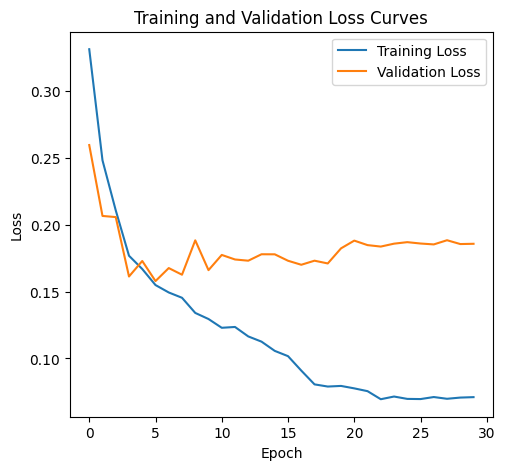

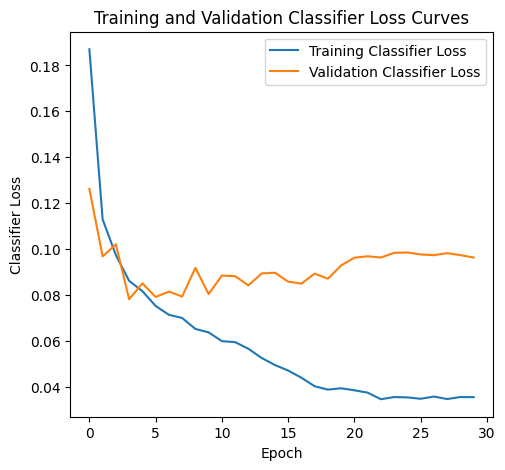

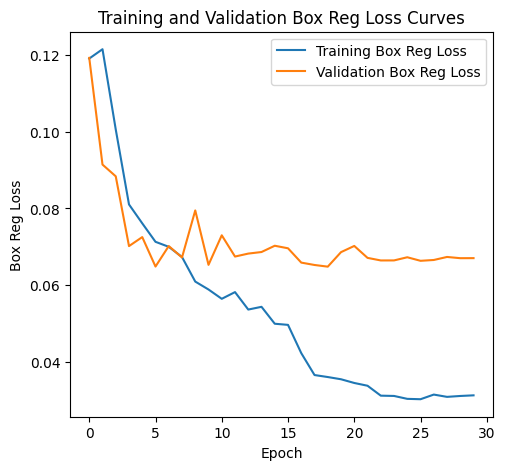

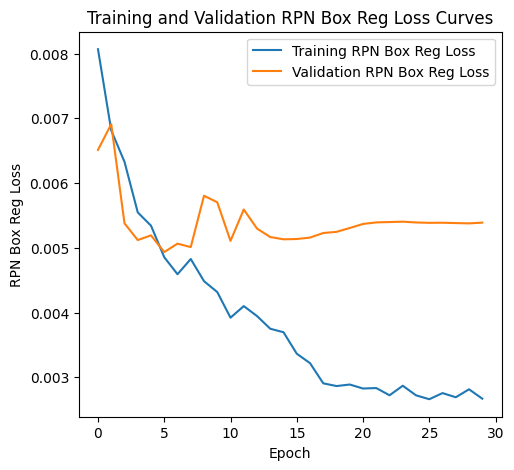

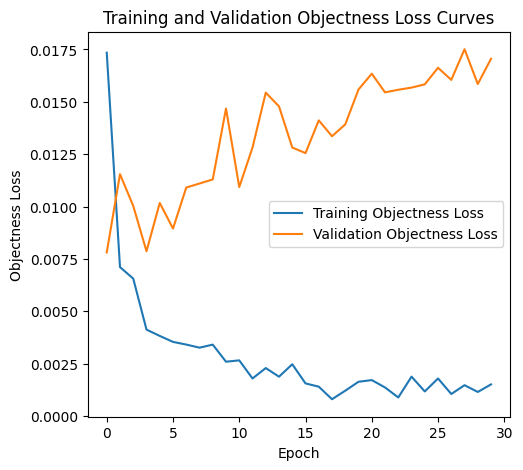

In [33]:
def main():
    
    seed_everything(config.seed)
    
    train_dataset = CXRDataset(root = config.root_2, split = "train", transforms = get_transforms(train = True))
    val_dataset = CXRDataset(root = config.root_2, split = "val", transforms = get_transforms(train = False))

    train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True, collate_fn = collate_fn)
    val_loader = DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False, collate_fn = collate_fn)
    
    device = config.device
    model =  fasterrcnn(num_classes = config.num_classes)
    model.to(device)
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(parameters, lr = config.lr, momentum = config.momentum, nesterov = True, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = config.milestones, gamma = config.gamma)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
    
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "val": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
    }
    
    for epoch in range(config.epochs):
        train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness = train_one_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness = validation(model, val_loader, device)
    
        history["train"]["loss"].append(train_loss)
        history["train"]["loss_classifier"].append(train_loss_classifier)
        history["train"]["loss_box_reg"].append(train_loss_box_reg)
        history["train"]["loss_rpn_box_reg"].append(train_loss_rpn_box_reg)
        history["train"]["loss_objectness"].append(train_loss_objectness)
        
        history["val"]["loss"].append(val_loss)
        history["val"]["loss_classifier"].append(val_loss_classifier)
        history["val"]["loss_box_reg"].append(val_loss_box_reg)
        history["val"]["loss_rpn_box_reg"].append(val_loss_rpn_box_reg)
        history["val"]["loss_objectness"].append(val_loss_objectness)
        
        print(f'Epoch: {epoch+1}/{config.epochs} | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        print("*****Training*****")
        print(f'Loss: {train_loss:.4f} | Classifier Loss: {train_loss_classifier:.4f} | Box Reg Loss: {train_loss_box_reg:.4f} | RPN Box Reg Loss: {train_loss_rpn_box_reg:.4f} | Objectness Loss: {train_loss_objectness:.4f}')
        evaluate(model, train_loader, device = device)
        print("*****Validation*****")
        print(f'Loss: {val_loss:.4f} | Classifier Loss: {val_loss_classifier:.4f} | Box Reg Loss: {val_loss_box_reg:.4f} | RPN Box Reg Loss: {val_loss_rpn_box_reg:.4f} | Objectness Loss: {val_loss_objectness:.4f}')
        evaluate(model, val_loader, device = device)
        
        if val_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = val_loss
            torch.save(save_file, "checkpoint.pth")
            
    best_ckpt = torch.load("checkpoint.pth", map_location = device)
    model.load_state_dict(best_ckpt["model"])
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config.epochs), history["val"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_classifier"], label = 'Training Classifier Loss')
    plt.plot(range(config.epochs), history["val"]["loss_classifier"], label = 'Validation Classifier Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Loss')
    plt.legend()
    plt.title('Training and Validation Classifier Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_box_reg"], label = 'Training Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_box_reg"], label = 'Validation Box Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation Box Reg Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_rpn_box_reg"], label = 'Training RPN Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_rpn_box_reg"], label = 'Validation RPN Box Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('RPN Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation RPN Box Reg Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_objectness"], label = 'Training Objectness Loss')
    plt.plot(range(config.epochs), history["val"]["loss_objectness"], label = 'Validation Objectness Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Objectness Loss')
    plt.legend()
    plt.title('Training and Validation Objectness Loss Curves')
    plt.show()
    
    
if __name__ == "__main__":
    main()

# 3


# predict and Visualization


In [34]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [config.categories[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            if pred_scores[index] >= detection_threshold:
                if pred_classes[index] not in classes:  # 避免取到重複的並(這是照疾病分數排的，所以可以取第一個看到的)
                    boxes.append(pred_bboxes[index].astype(np.int32))
                    classes.append(pred_classes[index])
                    labels.append(pred_labels[index])
                    indices.append(index)
    boxes = np.int32(boxes)
    
    return boxes, classes, labels, indices

COLORS = np.random.uniform(0, 255, size = (len(config.categories) , 3))
def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType = cv2.LINE_AA)
    return image

In [35]:
def get_transform():
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
    
    return transform

In [36]:
def plot_eigen_cam_images(transforms, model):
    
    rows, cols = 2, 4
    fig = plt.figure(figsize = (16, 10))
    grid = plt.GridSpec(rows, cols)
    
    best_ckpt = torch.load("/kaggle/working/checkpoint.pth", map_location = config.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config.device)
    target_layers = [model.backbone]
    
    cam = EigenCAM(model, 
                   target_layers, 
                   reshape_transform = fasterrcnn_reshape_transform)
    
    for i in range(rows * cols):
        all_images = os.listdir(os.path.join(config.root_2, config.categories[i]))
        image = Image.open(os.path.join(config.root_2, config.categories[i], all_images[0]))
        image = np.array(image)
        image = cv2.resize(image, (800, 800))
        image_float_np = np.float32(image) / 255
        
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config.device)
        input_tensor = input_tensor.unsqueeze(0)
        
        boxes, classes, labels, indices = predict(input_tensor, model, config.device, 0.12)
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels = labels, bounding_boxes = boxes)]
        
        grayscale_cam = cam(input_tensor, targets = targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
        
        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config.categories[i]}")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("EigenCAM Images of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()

In [37]:
def plot_ablation_cam_images(transforms, model):
    
    rows, cols = 2, 4
    fig = plt.figure(figsize = (16, 10))
    grid = plt.GridSpec(rows, cols)
    
    best_ckpt = torch.load("/kaggle/working/checkpoint.pth", map_location = config.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config.device)
    target_layers = [model.backbone]
    
    cam = AblationCAM(model,
                      target_layers,
                      reshape_transform = fasterrcnn_reshape_transform,
                      ablation_layer = AblationLayerFasterRCNN(),
                      ratio_channels_to_ablate = 1.0)
    
    for i in range(rows * cols):
        all_images = os.listdir(os.path.join(config.root_2, config.categories[i]))
        image = Image.open(os.path.join(config.root_2, config.categories[i], all_images[1]))
        image = np.array(image)
        image = cv2.resize(image, (800, 800))
        image_float_np = np.float32(image) / 255
        
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config.device)
        input_tensor = input_tensor.unsqueeze(0)
        
        boxes, classes, labels, indices = predict(input_tensor, model, config.device, 0.6)
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels = labels, bounding_boxes = boxes)]
        
        grayscale_cam = cam(input_tensor, targets = targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
        
        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config.categories[i]}")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("AblationCAM Images of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()

## Eigen CAM

In [38]:
# plot_eigen_cam_images(transforms = get_transform(), model = fasterrcnn(config.num_classes))

# Ablation CAM

100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


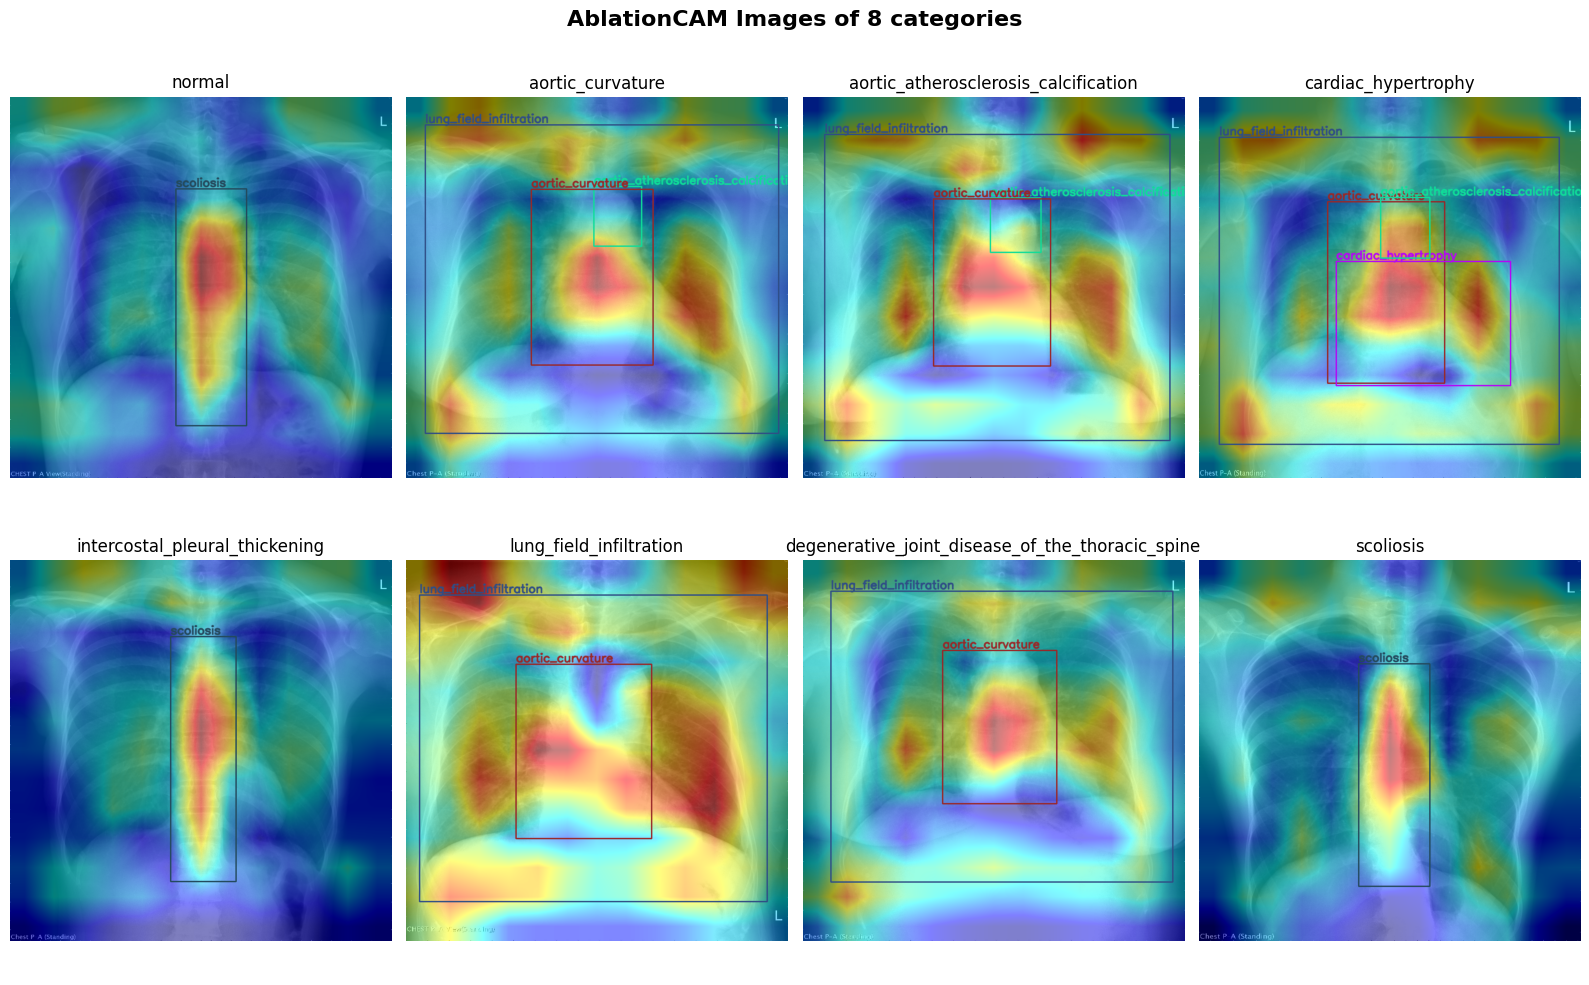

In [39]:
plot_ablation_cam_images(transforms = get_transform(), model = fasterrcnn(config.num_classes))

# predict 

In [40]:

test_df = pd.read_csv("/kaggle/input/miadl5/hwk05_data/test_UTF8.csv")
test_df


ID  Width  Height Filename       ImagePath
0    TDR02_20161123_145314   2328    2360  001.dcm  /image/001.dcm
1    TDR01_20171106_111727   2328    2424  002.dcm  /image/002.dcm
2    TDR01_20180510_090210   2296    2432  003.dcm  /image/003.dcm
3    TDR01_20180511_092549   2392    2576  004.dcm  /image/004.dcm
4    TDR04_20180316_084316   2328    2352  005.dcm  /image/005.dcm
..                     ...    ...     ...      ...             ...
108  TDR04_20180223_093206   2048    2480  109.dcm  /image/109.dcm
109  TDR02_20161125_122319   2096    2296  110.dcm  /image/110.dcm
110  TDR02_20180123_115426   2400    2544  111.dcm  /image/111.dcm
111  TDR01_20180508_173616   1536    1824  112.dcm  /image/112.dcm
112  TDR02_20161118_145330   2104    2456  113.dcm  /image/113.dcm

[113 rows x 5 columns]

In [41]:
# do X_ray_normalization and dcm_to_jpg

def dcm_to_jpg_test(df):
    
    for path in df.ImagePath:
        dcm_path = os.path.join("/kaggle/input/miadl5/hwk05_data/test"+path)
        _, _, image = X_ray_normalization(dcm_path, vmin = 0, vmax = 2.5)
        file = os.path.join("/kaggle/working/test_img") 
        jpg_name = path.split("/")[-1].replace(".dcm", ".jpg")
        
        if os.path.isdir(file) == False:
            os.makedirs(file)
        
        plt.imsave(f"{file}/{jpg_name}", image, cmap = "gray")
        
dcm_to_jpg_test(test_df)

In [42]:
# test_predict = {
#     "ID":[],
#     "category":[],
#     "score":[],
#     "xmin":[],
#     "xmax":[],
#     "ymin":[],
#     "ymax":[]
# }

# model = fasterrcnn(config.num_classes)
# best_ckpt = torch.load("/kaggle/working/checkpoint.pth", map_location = config.device)
# model.load_state_dict(best_ckpt["model"])
# model.eval().to(config.device)
# target_layers = [model.backbone]

# transforms = get_transform()

# all_images = os.listdir(os.path.join(config.root_2,'test_img')) 

# i=0

# image = Image.open(os.path.join('/kaggle/working/test_img/'+all_images[i]))
# image = np.array(image)
# image = cv2.resize(image, (800, 800))
# image_float_np = np.float32(image) / 255

# input_tensor = transforms(image)
# input_tensor = input_tensor.to(config.device)
# input_tensor = input_tensor.unsqueeze(0)

# outputs = model(input_tensor)
# pred_classes = [config.categories[i] for i in outputs[0]['labels'].cpu().numpy()]
# pred_labels = outputs[0]['labels'].cpu().numpy()
# pred_scores = outputs[0]['scores'].detach().cpu().numpy()
# pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

# boxes, classes, labels, indices, scores= [], [], [], [], []

# for index in range(len(pred_scores)):
#     if pred_scores[index] >= 0.12:
#         if pred_classes[index] not in classes:  # 避免取到重複的並(這是照疾病分數排的，所以可以取第一個看到的)
#             boxes.append(pred_bboxes[index].astype(np.int32))
#             classes.append(pred_classes[index])
#             labels.append(pred_labels[index])
#             indices.append(index)
#             scores.append(pred_scores[index])

# [classes,scores]

In [43]:

def predict_test(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [config.categories[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices, scores= [], [], [], [], []
    class_seen = [] 
    
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            if pred_classes[index] not in classes:  # 避免取到重複的並(這是照疾病分數排的，所以可以取第一個看到的)
                boxes.append(pred_bboxes[index].astype(np.int32))
                classes.append(pred_classes[index])
                labels.append(pred_labels[index])
                indices.append(index)
                scores.append(pred_scores[index])
    boxes = np.int32(boxes)
    
    return boxes, classes, labels, indices,scores


In [44]:
# 預測test  
# 需要ID,category、score、xmin、xmax、ymin、ymax。
test_predict = {
    "ID":[],
    "category":[],
    "score":[],
    "xmin":[],
    "xmax":[],
    "ymin":[],
    "ymax":[]
}

model = fasterrcnn(config.num_classes)
best_ckpt = torch.load("/kaggle/working/checkpoint.pth", map_location = config.device)
model.load_state_dict(best_ckpt["model"])
model.eval().to(config.device)
target_layers = [model.backbone]

transforms = get_transform()

all_images = os.listdir(os.path.join(config.root_2,'test_img')) 
for i in range(len(all_images)):
    image = Image.open(os.path.join('/kaggle/working/test_img/'+all_images[i]))
    image = np.array(image)
    image = cv2.resize(image, (800, 800))
    image_float_np = np.float32(image) / 255
    
    input_tensor = transforms(image)
    input_tensor = input_tensor.to(config.device)
    input_tensor = input_tensor.unsqueeze(0)
    
    boxes, classes, labels, indices,scores = predict_test(input_tensor, model, config.device, 0.6)
    for j in range(len(classes)):
        test_predict["ID"].append(test_df["ID"][i])
        test_predict["category"].append(classes[j])
        test_predict["score"].append(scores[j])
        test_predict["xmin"].append(boxes[:,0][j]/test_df["Width"][i])
        test_predict["xmax"].append(boxes[:,2][j]/test_df["Width"][i])
        test_predict["ymin"].append(boxes[:,1][j]/test_df["Height"][i])
        test_predict["ymax"].append(boxes[:,3][j]/test_df["Height"][i])

test_predict_df = pd.DataFrame(test_predict)
test_predict_df
    

ID                              category     score  \
0    TDR02_20161123_145314                             scoliosis  0.726987   
1    TDR02_20161123_145314               lung_field_infiltration  0.619555   
2    TDR01_20171106_111727                      aortic_curvature  0.725145   
3    TDR01_20171106_111727               lung_field_infiltration  0.697289   
4    TDR01_20180510_090210                      aortic_curvature  0.763046   
..                     ...                                   ...       ...   
238  TDR02_20161125_122319  aortic_atherosclerosis_calcification  0.733285   
239  TDR02_20180123_115426                             scoliosis  0.715402   
240  TDR01_20180508_173616                      aortic_curvature  0.702484   
241  TDR01_20180508_173616                             scoliosis  0.606369   
242  TDR02_20161118_145330                             scoliosis  0.827173   

         xmin      xmax      ymin      ymax  
0    0.155928  0.220361  0.080508  0.267373  
1    0.023196  0.336770  0.036864  0.306780  
2    0.121564  0.217784  0.083746  0.245050  
3    0.020619  0.326031  0.036716  0.303218  
4    0.135889  0.227352  0.089227  0.237664  
..        ...       ...       ...       ...  
238  0.186069  0.238550  0.100174  0.152003  
239  0.145833  0.208333  0.076651  0.258255  
240  0.190755  0.326172  0.117325  0.309211  
241  0.216146  0.311849  0.150219  0.353070  
242  0.155418  0.224335  0.094463  0.254072  

[243 rows x 7 columns]

In [45]:
test_predict_df.to_csv('311657020.csv',index = False)